In [246]:
# 从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [247]:
# 根据带有噪声的线性模型构造一个人造数据集。
# 使用线性模型参数 w=[2,-3.4]的转置、b=4.2 和噪声ε生成数据集及标签：y=Xw+b+ε
def synthetic_data(w,b,num_examples):
    """生成 y = XW + b + 噪声。"""
    X = torch.normal(0,1,(num_examples, len(w))) # 均值为0，方差为1的随机数，“num_examples”是行数，“len(w)”是列数
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1,1))

In [248]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # 得到训练样本

In [249]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.1762,  1.0682]) 
label: tensor([0.1906])


In [250]:
d2l.set_figsize()

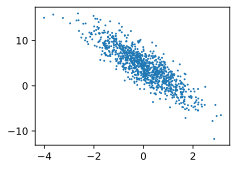

In [251]:
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1)

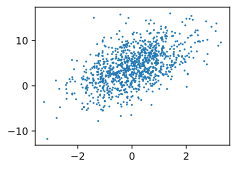

In [252]:
d2l.plt.scatter(features[:,0].detach().numpy(), labels.detach().numpy(), 1)

In [253]:
# 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [254]:
batch_size = 10

In [255]:
for X,y in data_iter(batch_size, features, labels):
    print(X,'\n',y)
    break

tensor([[ 0.6050, -0.5510],
        [-1.0999, -0.2274],
        [-0.4386, -1.5225],
        [ 0.7066,  1.6584],
        [ 0.4319,  0.0781],
        [-1.6499,  0.5369],
        [ 0.6429,  0.8356],
        [ 2.1882,  0.2834],
        [-1.6753,  0.4163],
        [ 0.8127,  1.6214]]) 
 tensor([[ 7.3011],
        [ 2.7777],
        [ 8.4763],
        [-0.0184],
        [ 4.7969],
        [-0.9207],
        [ 2.6564],
        [ 7.5943],
        [-0.5547],
        [ 0.3131]])


In [256]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w , b

(tensor([[-0.0150],
         [-0.0018]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [257]:
# 定义模型
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w)+b

In [258]:
# 定义损失函数
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [259]:
# 定义优化算法
# params: w b 
# lr: 学习率
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        iter_num = 0
        for param in params:
            if iter_num==0:
                param_name='w'
            else:
                param_name='b'
            print(f"-----------{param_name}.grad-----------")
            print(param.grad)
            param -= lr * param.grad / batch_size
            iter_num += 1
            param.grad.zero_()

In [260]:
# 训练过程
lr = 0.03
num_epochs = 3 # 训练轮数
net = linreg # 模型（可换成别的模型）
loss = squared_loss # 损失函数

In [261]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b),y) # 'x'和'y'的小批量损失
        # 因为‘l’形状是（‘batch_size’,1）,而不是一个标量。 ‘l’中的所有元素被加到一起，求和，转化为标量，便于计算
        # 并以此计算关于 ['w','b']的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'----------------------------------------------------------epoch{epoch + 1}, loss{float(train_l.mean()):f}')

-----------w.grad-----------
tensor([[-2.8907],
        [54.3741]])
-----------b.grad-----------
tensor([-25.9076])
-----------w.grad-----------
tensor([[-44.0929],
        [ 52.2253]])
-----------b.grad-----------
tensor([-51.7639])
-----------w.grad-----------
tensor([[ 9.7555],
        [58.6658]])
-----------b.grad-----------
tensor([-42.5324])
-----------w.grad-----------
tensor([[-72.9404],
        [ 46.2099]])
-----------b.grad-----------
tensor([-42.3647])
-----------w.grad-----------
tensor([[-31.0974],
        [ 71.5823]])
-----------b.grad-----------
tensor([-45.2045])
-----------w.grad-----------
tensor([[-39.0794],
        [ 25.2166]])
-----------b.grad-----------
tensor([-40.3889])
-----------w.grad-----------
tensor([[-17.3907],
        [  0.2302]])
-----------b.grad-----------
tensor([-22.2086])
-----------w.grad-----------
tensor([[ 5.8055],
        [14.5960]])
-----------b.grad-----------
tensor([-17.2837])
-----------w.grad-----------
tensor([[-1.6895],
        [16.52

In [262]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 5.5194e-05, -7.1311e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0008], grad_fn=<RsubBackward1>)
